# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Implementation](#implementation)
4. [Evaluation Metrics](#evaluation-metrics)
5. [Comparative Analysis](#comparative-analysis)


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler


## Model Selection

The following documentaion part shows two models which represent two states of model developing: The state after the baseline model and and the best performing model, respectively. Both models use the same features, only the architecture differs.

Model: Simple Neural Network  
This improved baseline model contains as a first model all needed features and is build of
- one input dense layer
- one hidden dense layer
- one output layer

It shows how a simple neural network performs in a topic of periodic data.

Model: Long-Short-Term-Memory  
In general, Long-Short-Term-Memory (LSTM) models are able to recognize periodicity. Therefore, it is not surprisingly that it achieves better results for tide gauge forecasting than the first mentioned model. Is is built of
- two LSTM layers
- one hidden dense layer
- one output layer

and is the best performing model in this project.

Additional to these two models, several architectures are built and evaluated which lead us to the LSTM model. This progress of developing is excluded of the documentation because it does not show any further necessary information.

## Feature Engineering

Summary of feature and data engineering with respect to the baseline model
- 3 features instead of 1
- bigger output length
- normed as in baseline model
- tensorflow dataset for
- batchsize and window shuffle

We used the following three features: Wind speed towards east, wind speed towards nord (both over Helgoland) and tide gauge at St. Pauli. The wind speed over Helgoland has a crucial role because at certain conditions the wind pushes the water towards the German Bay with potential effects such as overflow.  
The prediction time span is increased to 6 hours instead of one because this makes the model more applicable. The input length of 48 hours are the same as for the baseline model.  
The input data is normalized as for the baseline model.  
The datasets a transformed to tensorflow datasets since it handles parameters such as window shuffle and batch size better.  
Batch size is 2048 for a fast training. E.g. one epoch with batch size 16 needs ca. 2.5min but with batch size 2048 it hardly needs 1min for training.  
The window shuffle is 1200 to neglect possible biases. Without shuffling the results would probably be the same.

In [2]:
# Functions needed for Feature Engineering
def create_training_data(data, feature_size, output_size):
    """
    Create training data for a neural network using a moving window approach.

    Parameters:
    - data: Input dataframe containing time series data.
    - feature_size: Size of the input features for each sample.
    - output_size: Size of the output for each sample.

    Returns:
    - X: Features array.
    - y: Corresponding labels array.
    """
    X, y = [], []

    for series_num in data['NUMBER'].unique():
        series_data = data[data['NUMBER'] == series_num][['TIDE', 'MERI', 'ZONAL']]

        for i in range(len(series_data) - feature_size - output_size + 1):
            feature_window = series_data.iloc[i:i+feature_size].values
            output_window = series_data.iloc[i+feature_size:i+feature_size+output_size]['TIDE'].values

            X.append(feature_window)
            y.append(output_window)

    return np.array(X), np.array(y)


def scale_reshape(ds,features=3):
  """
  scales all features of the data to have a mean of 0 and a standart variation of 1
  flattens the 3 dimensional array to 2 dimensions
  """
  scaler = StandardScaler()
  ds_norm = ds.copy()
  for i in range(features):
    ds_norm[:,:,i] = scaler.fit_transform(ds[:,:,i])

  # flatten to 2d but only wind vectors are flatten
  shape = np.shape(ds_norm)
  ds_2d = ds_norm.reshape((shape[0]),shape[1]*shape[2])

  return ds_norm,ds_2d


def edit_tf_dataset(tf_dataset,batch_size,shuffle_buffer):
  """
  function shuffles windows and creates batches for faster training
  """
  # Shuffle the windows
  tf_dataset = tf_dataset.shuffle(shuffle_buffer)

  # Create batches of windows
  tf_dataset = tf_dataset.batch(batch_size).prefetch(1)

  return tf_dataset


In [4]:
#Import the data
data_path = "https://github.com/LudwigMeder/Time-Series-Prediction-of-the-Tide-Gauge-in-St.-Pauli/blob/e85f8a66bcad4a41f0563c90f700ad1c120f240d/3_Model/data_with_helgoland_wind.csv"
data = pd.read_csv(data_path)

print(data)

#specify feature and label size
input_length = 48
output_length = 6

#specify how many parameters are used (tide, x-wind, y-wind)
features = 3

#call the function to get the features and labels out of the dataframe
X,y = create_training_data(data, input_length, output_length)

#do train test split on the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(np.shape(X_train),np.shape(X_test),np.shape(y_train),np.shape(y_test))

# scaling X_train and X_test
## scaling slightly improves results
X_train_norm, X_train_2d = scale_reshape(X_train)
X_test_norm, X_test_2d = scale_reshape(X_test)

# converting data to tensor flow dataset
## tf_dataset_..._2d is needed for Simple neural network, tf_dataset_..._norm is needed for LSTM model; only difference is shape, both datasets are normalized
tf_dataset_train_2d = tf.data.Dataset.from_tensor_slices((X_train_2d,y_train))
tf_dataset_test_2d = tf.data.Dataset.from_tensor_slices((X_test_2d,y_test))

tf_dataset_train_norm = tf.data.Dataset.from_tensor_slices((X_train_norm,y_train))
tf_dataset_test_norm = tf.data.Dataset.from_tensor_slices((X_test_norm,y_test))

# creating batches for faster training and shuffles windows for lower bias
batch_size = 32
shuffle_buffer_size = 1200

tf_dataset_train_2d = edit_tf_dataset(tf_dataset_train_2d,batch_size,shuffle_buffer_size)
tf_dataset_train_norm = edit_tf_dataset(tf_dataset_train_norm,batch_size,shuffle_buffer_size)

##### Done with editing data #####

         TIDE          MERI      ZONAL  NUMBER
0        86.0  2.187967e+00 -12.408578       0
1       203.0  3.796424e+00 -10.430588       0
2       281.0  1.788576e+00 -10.143520       0
3       322.0  1.788576e+00 -10.143520       0
4       328.0 -1.726752e-15  -9.400000       0
...       ...           ...        ...     ...
196515   42.6 -5.335137e+00  -6.358169      86
196516  130.6 -3.850000e+00  -6.668396      86
196517  185.6 -5.515520e+00  -4.628071      86
196518  224.6 -6.894400e+00  -5.785088      86
196519  235.6 -6.684991e+00  -7.966862      86

[196520 rows x 4 columns]
(153761, 48, 3) (38441, 48, 3) (153761, 6) (38441, 6)


## Implementation
Before the models implementation, a callback function is defined which simply saves the trained model whenever the validation loss reaches a new lowest value. Therefore, a break during the training does not really matter, due to connection problems with google colab, and the training can be continued later after loading the model.

For all models we use the optimizer "adam" because we are satisfied with its outcome, in general. The same counts for the loss function "mean squared error" which is chosen because the task of tide gauge prediction is of mathematical nature and the root mean squared error is also used as metrics.

The output activation function linear is chosen because the output value should be unconstrained.


### Callbacks
In this section, we create a custom Callback function that monitors both training and test losses while saving the model that demonstrates the best performance on the test data.

In [5]:
class LossLoggerCallback(tf.keras.callbacks.Callback):
    def __init__(self, model_filename='best_model.h9'):
        super(LossLoggerCallback, self).__init__()
        self.model_filename = model_filename
        self.best_val_loss = float('inf')
        self.hist_train = []
        self.hist_test = []

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        train_loss = logs.get('loss')
        val_loss = logs.get('val_loss')
        self.hist_train.append(train_loss)
        self.hist_test.append(val_loss)

        # Save the model if the current validation loss is lower than the previous best
        if val_loss is not None and val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            #self.model.save(self.model_filename)
            self.model.save("/content/drive/My Drive/Colab Notebooks/fishmarkt/model_saving.h9")
            print(f'Saving the best model to {self.model_filename}')

### Simple Neural Network

In [ ]:
model_simple = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=64,input_shape = (None,input_length*features)),
    tf.keras.layers.Dense(units=64,activation="relu"),
    tf.keras.layers.Dense(units=output_length,activation="linear")
    ])
model_simple.summary()

#compile model and get summary
model_simple.compile(optimizer='adam', loss='mean_squared_error')

# fit model on training data
history_simple = model_simple.fit(tf_dataset_train_2d, validation_data = (X_test_2d, y_test), epochs=100)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 64)          9280      
                                                                 
 dense_1 (Dense)             (None, None, 64)          4160      
                                                                 
 dense_2 (Dense)             (None, None, 6)           390       
                                                                 
Total params: 13830 (54.02 KB)
Trainable params: 13830 (54.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
76/76 [==============================] - 4s 40ms/step - loss: 15085.4180 - val_loss: 7935.3057
Epoch 2/100
76/76 [==============================] - 3s 45ms/step - loss: 3010.4900 - val_loss: 1428.5706
Epoch 3/100
76/76 [==============================] - 2s 29ms/step - los

### LSTM Model

In [ ]:
lstm_v2_logger = LossLoggerCallback(model_filename='best_lstm_v1.h9')
model_lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units = 64, input_shape = (input_length,features), return_sequences = True),
    tf.keras.layers.LSTM(units = 128),
    tf.keras.layers.Dense(units = 64,activation='relu'),
    tf.keras.layers.Dense(units = 128,activation='relu'),
    tf.keras.layers.Dense(units = output_length,activation='linear')
])
model_lstm.summary()

#compile model and get summary
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# fit model on training data
history_lstm = model_lstm.fit(tf_dataset_train_norm, validation_data = (X_test_norm, y_test),epochs=300, callbacks=[lstm_v2_logger])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 64)            17408     
                                                                 
 lstm_1 (LSTM)               (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 133574 (521.77 KB)
Trainable params: 133574 (521.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
301/

In [ ]:
model_load = tf.keras.models.load_model("/content/drive/My Drive/Colab Notebooks/fishmarkt/model_saving.h9")

In [ ]:
lstm_v2_logger = LossLoggerCallback(model_filename='best_lstm_v1.h9')
history_lstm_load = model_load.fit(tf_dataset_train_norm, validation_data = (X_test_norm, y_test),epochs=150, callbacks=[lstm_v2_logger])

Epoch 1/150
1202/1202 [==============================] - 330s 271ms/step - loss: 274.0263 - val_loss: 280.7804
Epoch 2/150
1202/1202 [==============================] - 329s 274ms/step - loss: 262.7835 - val_loss: 279.0910
Epoch 3/150
1202/1202 [==============================] - 330s 275ms/step - loss: 251.7156 - val_loss: 253.1641
Epoch 4/150
1202/1202 [==============================] - 317s 263ms/step - loss: 246.9833 - val_loss: 240.3966
Epoch 5/150
1202/1202 [==============================] - 329s 273ms/step - loss: 237.3253 - val_loss: 226.1782
Epoch 6/150
1202/1202 [==============================] - 320s 267ms/step - loss: 231.1560 - val_loss: 226.0425
Epoch 7/150
1202/1202 [==============================] - 322s 268ms/step - loss: 223.6262 - val_loss: 241.4134
Epoch 8/150
1202/1202 [==============================] - 330s 275ms/step - loss: 215.9520 - val_loss: 219.1190
Epoch 9/150
1202/1202 [==============================] - 332s 276ms/step - loss: 208.5013 - val_loss: 224.0703
E

In [ ]:
model_load = tf.keras.models.load_model("/content/drive/My Drive/Colab Notebooks/fishmarkt/model_saving.h9")

In [ ]:
lstm_v2_logger = LossLoggerCallback(model_filename='best_lstm_v1.h9')
history_lstm_load = model_load.fit(tf_dataset_train_norm, validation_data = (X_test_norm, y_test),epochs=15, callbacks=[lstm_v2_logger])

Epoch 1/15
1202/1202 [==============================] - 322s 264ms/step - loss: 75.0576 - val_loss: 94.3977
Epoch 2/15
1202/1202 [==============================] - 301s 250ms/step - loss: 72.2514 - val_loss: 96.8272
Epoch 3/15
1202/1202 [==============================] - 302s 251ms/step - loss: 70.6030 - val_loss: 98.5558
Epoch 4/15
1202/1202 [==============================] - 303s 252ms/step - loss: 68.9652 - val_loss: 96.4335
Epoch 5/15
1202/1202 [==============================] - 304s 253ms/step - loss: 81.6544 - val_loss: 95.2745
Epoch 6/15
1202/1202 [==============================] - 307s 256ms/step - loss: 66.4880 - val_loss: 93.1708
Epoch 7/15
1202/1202 [==============================] - 303s 253ms/step - loss: 66.2678 - val_loss: 97.2398
Epoch 8/15
1202/1202 [==============================] - 305s 254ms/step - loss: 66.5787 - val_loss: 94.6916
Epoch 9/15
1202/1202 [==============================] - 313s 260ms/step - loss: 72.6667 - val_loss: 90.9094
Epoch 10/15
1202/1202 [=====

KeyboardInterrupt: 

In [ ]:
model_load = tf.keras.models.load_model("/content/drive/My Drive/Colab Notebooks/fishmarkt/model_saving.h9")

In [ ]:
lstm_v2_logger = LossLoggerCallback(model_filename='best_lstm_v1.h9')
history_lstm_load = model_load.fit(tf_dataset_train_norm, validation_data = (X_test_norm, y_test),epochs=50, callbacks=[lstm_v2_logger])

Epoch 1/50
4806/4806 [==============================] - 520s 108ms/step - loss: 100.0843 - val_loss: 119.9571
Epoch 2/50
4806/4806 [==============================] - 511s 106ms/step - loss: 100.8733 - val_loss: 109.4025
Epoch 3/50
4806/4806 [==============================] - 553s 115ms/step - loss: 86.6378 - val_loss: 110.7272
Epoch 4/50
4806/4806 [==============================] - 552s 115ms/step - loss: 89.7928 - val_loss: 109.1451
Epoch 5/50
4806/4806 [==============================] - 499s 104ms/step - loss: 92.9812 - val_loss: 113.4651
Epoch 6/50
4806/4806 [==============================] - 504s 105ms/step - loss: 95.2083 - val_loss: 105.3629
Epoch 7/50
4806/4806 [==============================] - 533s 111ms/step - loss: 78.7374 - val_loss: 106.7932
Epoch 8/50
4806/4806 [==============================] - 534s 111ms/step - loss: 83.3616 - val_loss: 118.1111
Epoch 9/50
4806/4806 [==============================] - 526s 110ms/step - loss: 84.4159 - val_loss: 96.7593
Epoch 10/50
4806/4

In [6]:
model_load = tf.keras.models.load_model("/content/drive/My Drive/Colab Notebooks/fishmarkt/model_saving.h9")

In [7]:
lstm_v2_logger = LossLoggerCallback(model_filename='best_lstm_v1.h9')
history_lstm_load = model_load.fit(tf_dataset_train_norm, validation_data = (X_test_norm, y_test),epochs=50, callbacks=[lstm_v2_logger])

Epoch 1/50
4806/4806 [==============================] - 309s 64ms/step - loss: 89.8317 - val_loss: 96.6846
Epoch 2/50
4806/4806 [==============================] - 318s 66ms/step - loss: 75.4357 - val_loss: 95.5657
Epoch 3/50
4806/4806 [==============================] - 311s 65ms/step - loss: 72.9217 - val_loss: 106.4773
Epoch 4/50
4806/4806 [==============================] - 304s 63ms/step - loss: 71.7275 - val_loss: 97.5601
Epoch 5/50
4806/4806 [==============================] - 306s 64ms/step - loss: 73.4917 - val_loss: 94.7134
Epoch 6/50
4806/4806 [==============================] - 303s 63ms/step - loss: 75.7241 - val_loss: 95.6782
Epoch 7/50
4806/4806 [==============================] - 301s 63ms/step - loss: 69.4380 - val_loss: 96.8054
Epoch 8/50
4806/4806 [==============================] - 305s 64ms/step - loss: 74.2022 - val_loss: 93.4849
Epoch 9/50
4806/4806 [==============================] - 309s 64ms/step - loss: 66.2554 - val_loss: 91.6473
Epoch 10/50
4806/4806 [=============

## Evaluation Metrics

First of all, we used the training loss and validation loss values to observe the training development of the models. These values are the mean squared error between the 6 hours of real and forecast data.   
The mean squared error directly gives the uncertainty of the model.  
After training, the unseen test data is predicted by the model and therefore indicates the overall performance. Furthermore, the error has to be compared with the thresholds of floods at St. Pauli to get a realistic evaluation of the model and it has to be compared with the error of the simple neural network and the baseline model to assess a possible progress. For the latter it is difficult to compare because the baseline's output is only one hour and there is also only one input feature instead of three.

In [8]:
# Function to predict and therefore to evaluate
def model_forecast(model, tf_dataset, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Create batches of windows
    tf_dataset = tf_dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(tf_dataset)

    return forecast

### Simple Neural Network

19/19 [==============================] - 0s 13ms/step
The rmse over all predicted data equals  17.371972795032104


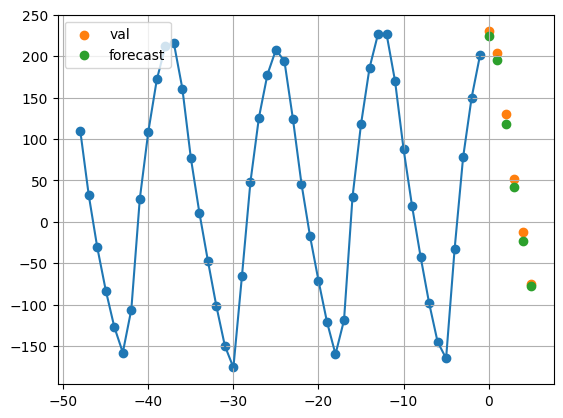

In [ ]:
forecast = model_forecast(model_simple, tf_dataset_test_2d, batch_size)
# calculate root mean square error
rmse = np.sqrt(mean_squared_error(y_test,forecast))
print("The rmse over all predicted data equals ",rmse)
# plot results
time = np.arange(-48,6)
Tide = X_test[:,:,0]
index = 100 #range between 0 and 482
plt.scatter(time, np.concatenate([Tide[index,:],np.ones(6)*np.nan]))
plt.plot(time, np.concatenate([Tide[index,:],np.ones(6)*np.nan]))
plt.scatter(time,np.concatenate([np.ones(48)*np.nan,y_test[100]]),label='val')
plt.scatter(time,np.concatenate([np.ones(48)*np.nan,forecast[100]]),label='forecast')
plt.legend()
plt.grid()


The x - axis starts with epoch number  9 .


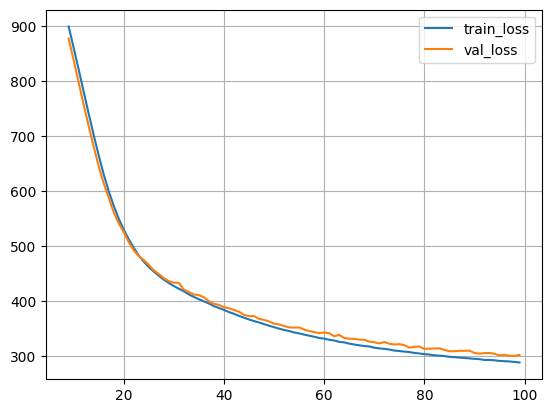

In [ ]:
start = 9 # beginn of epoch number
loss_simple=history_simple.history['loss']
val_loss_simple = history_simple.history['val_loss']
plt.plot(np.arange(len(loss_simple))[start:],loss_simple[start:],label='train_loss')
plt.plot(np.arange(len(loss_simple))[start:],val_loss_simple[start:],label='val_loss')
plt.legend()
plt.grid()
print("The x - axis starts with epoch number ",start,".")

### LSTM Model

In [23]:
forecast = model_forecast(model_load, tf_dataset_test_norm, batch_size)
# calculate root mean square error
rmse = np.sqrt(mean_squared_error(y_test,forecast))
print("The rmse over all predicted data equals ",rmse)

1202/1202 [==============================] - 33s 28ms/step
The rmse over all predicted data equals  8.790244586777547


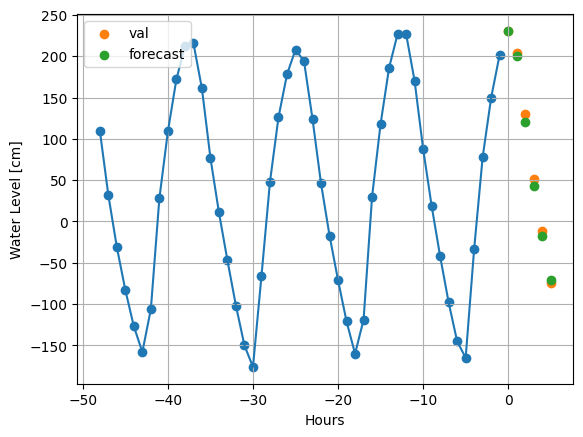

In [26]:
# plot results
time = np.arange(-48,6)
Tide = X_test[:,:,0]
index = 100 #range between 0 and 482
plt.scatter(time, np.concatenate([Tide[index,:],np.ones(6)*np.nan]))
plt.plot(time, np.concatenate([Tide[index,:],np.ones(6)*np.nan]))
plt.scatter(time,np.concatenate([np.ones(48)*np.nan,y_test[100]]),label='val')
plt.scatter(time,np.concatenate([np.ones(48)*np.nan,forecast[100]]),label='forecast')
plt.xlabel("Hours")
plt.ylabel("Water Level [cm]")
plt.legend()
plt.grid()


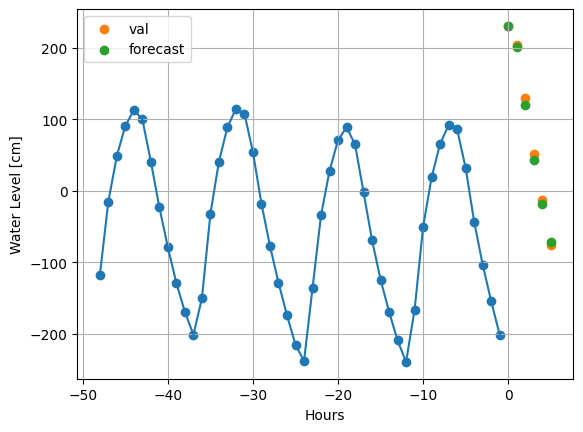

In [27]:
time = np.arange(-48,6)
Tide = X_test[:,:,0]
index = 500 #range between 0 and 482
plt.scatter(time, np.concatenate([Tide[index,:],np.ones(6)*np.nan]))
plt.plot(time, np.concatenate([Tide[index,:],np.ones(6)*np.nan]))
plt.scatter(time,np.concatenate([np.ones(48)*np.nan,y_test[100]]),label='val')
plt.scatter(time,np.concatenate([np.ones(48)*np.nan,forecast[100]]),label='forecast')
plt.xlabel("Hours")
plt.ylabel("Water Level [cm]")
plt.legend()
plt.grid()

The x - axis starts with epoch number  9 .


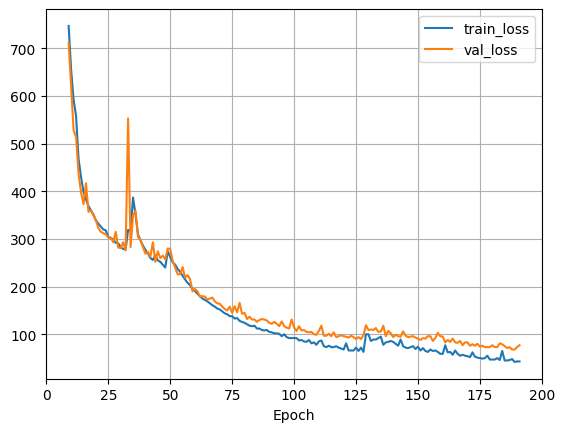

In [28]:
# loss and validation loss - list written by hand, because after a training break up, the values are not stored anymore but they are still visuable
loss = [12720,10708,7840,1818,1980,1264,1231,1036,824,747,655,592,558,468,430,399,383,369,360,351,339,332,326,320,318,304,302,299,292,291,283,279,278,319,317,387,351,309,297,286,277,270,260,256,266,255,252,246,240,274,262,251,246,237,231,223,215,208,203,195,191,185,180,175,172,169,165,161,158,154,152,148,144,142,138,138,133,134,128,126,124,121,118,117,118,112,112,109,108,109,105,104,102,102,101,96,100,94,92,92,92,92,87,88,85,84,88,81,83,78,85,87,75,73,76,73,73,75,72,70,68,81,66,66,66,72,65,72,63,100,100,86,89,89,92,95,78,83,84,86,84,80,76,89,75,72,71,73,75,69,74,66,71,65,63,68,65,66,63,59,59,77,62,63,57,66,59,55,57,55,54,52,62,53,51,50,49,50,55,47,47,47,50,46,65,45,45,46,48,42,43,43]
val_loss = [11034,10150,2246,2676,1326,1116,1062,884,744,712,618,528,514,437,398,373,417,357,360,350,339,323,315,312,310,303,303,293,315,282,281,293,276,553,283,350,359,304,298,283,269,273,263,293,252,274,260,265,257,280,279,253,240,226,226,241,219,224,216,190,195,190,179,180,179,173,175,177,169,165,164,158,153,150,158,145,159,146,166,143,145,132,137,131,131,126,130,132,131,129,124,122,126,122,117,127,117,114,112,131,114,107,117,108,109,105,104,105,100,99,107,118,97,97,101,96,104,94,96,98,96,95,93,97,94,90,94,90,98,119,109,110,109,113,105,106,118,96,107,102,94,99,96,95,106,97,94,95,96,93,91,88,92,91,96,96,86,92,103,96,95,83,88,84,91,83,82,86,77,83,83,76,79,76,80,74,76,73,73,73,77,73,73,81,79,75,71,73,68,68,73,77]

start = 9 # beginn of epoch number
loss_lstm=loss
val_loss_lstm = val_loss
plt.plot(np.arange(len(loss_lstm))[start:],loss_lstm[start:],label='train_loss')
plt.plot(np.arange(len(loss_lstm))[start:],val_loss_lstm[start:],label='val_loss')
plt.legend()
plt.xlabel("Epoch")
plt.grid()
print("The x - axis starts with epoch number ",start,".")

## Comparative Analysis

The performances of the three models (baseline, simple neural network, LSTM), measured with the root mean squared error (RMSE) are the following:
- Performance Baseline model (1 output hour): RMSE = 12.14cm
- Performance simple NN (6 output hours): RMSE = 17.37cm
- Performance LSTM (6 output hours): RMSE = 8.80cm

The performance of the baseline model should be considered seperately because of the different input and output structure. It simply shows the first approach of the project with a RMSE of 12.14cm for one hour prediction and 48 hours water level observations as input feature.  
The simple neural network consideres the final input/output structure with 48 hours water level observations, zonal and meridional wind speed as input and 6 hours of water level as prediction. It achieves a RMSE of 17.37cm when trained with a large batch size (1024) and 100 epochs.  
The LSTM model, which performed the best, on the other hand, reached a RMSE of 8.80cm and therefore halved the uncertainty. But the training took much longer with 192 epochs and different batch sizes. Although large batch sizes result into faster running epochs, at a certain point the loss values did not decrease anymore. Due to training interruptions the batch size was adapted and thus the loss values droped again. Unfortunately, the uncertainty is now slightly bigger than given on the presentation due to a retraining, but nevertheless the LSTM model improved the forecast significantly with respect to the simple neural network.  
Regarding the tide gauge in St. Pauli, the model is aware of the wind - water level connection and is even able to predict high jumps in the water level as shown in the example above


